In [ ]:
#Code for setting initial random alarm time & threshold
#by Minyoung Kim 2024.10.01
# added HR calculation by Jinhee Kim (2024.10.01)

In [3]:
!pip install mysql-connector-python
!pip install azure-storage-blob
!pip install heartpy
!pip install neurokit2
!pip install gspread google-auth

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import heartpy as hp
import neurokit2 as nk
from datetime import datetime
import matplotlib
from google.colab import auth
import gspread
from google.auth import default
import pandas as pd
import mysql.connector
from azure.storage.blob import BlobServiceClient
import io
import warnings
import numpy as np
warnings.filterwarnings('ignore')

## Step 1: Obtaining heart rate from HRV task

연구대상자 user_ID를 입력하세요: PYS8293
실험 날짜 (예: 20240814): 20241002
File: PYS8293_HRV_ECG_20241002081615.txt
Numbers of negative value :  0
Sampling rate:  50
HRV start:  2024-10-02 08:10:45.430000
HRV end:  2024-10-02 08:16:15.705000
PYS8293 참가자의 평균 심박률은 79.84908739966438이다.
Lower threshold (심박률): 65.0
Upper threshold (심박률): 103.0


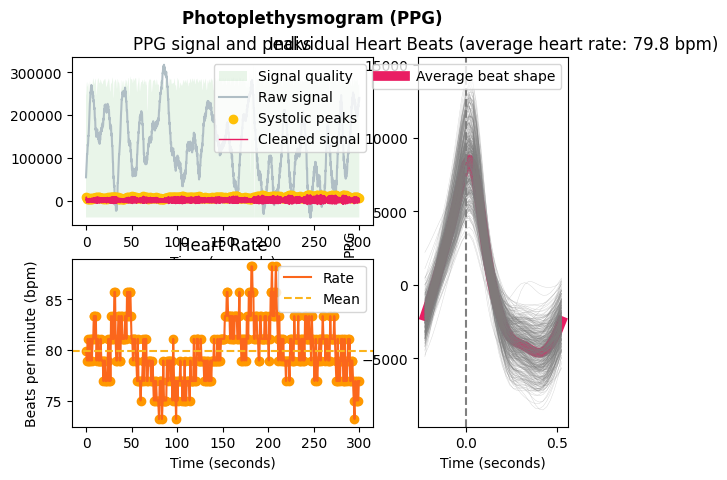

In [13]:

subname = input("연구대상자 user_ID를 입력하세요: ")
date_exp = input('실험 날짜 (예: 20240814): ')

###################### 1. Azure 접속 #####################################################
# Azure Storage 계정 및 키
account_name = 'kucogstorage'
account_key = 'fIZTWAZx66FcGqqCWz/PhPdzfyM6Wrx0yaQbXx2eap7fZ3U7BNruRXDp27/Px1mgPIHXxMsRQk1S+AStXVdugA=='
container_name = 'se-watch-v2'
# BlobServiceClient 생성
blob_service_client = BlobServiceClient(account_url=f"https://{account_name}.blob.core.windows.net",
                                        credential=account_key)
# ContainerClient 생성
container_client = blob_service_client.get_container_client(container_name)

################################################ 1.  HRV QC ########################################
    ### HR 정보 가져오기

target_folder_HR = f'data/{subname}/MS/HRV'
# 조건에 맞는 파일 목록 가져오기
blob_list = container_client.list_blobs(name_starts_with=target_folder_HR)
relevant_blobs = []

# Iterate through the blobs and add to relevant_blobs based on a condition
for blob in blob_list:
    # You can add any condition here to filter files
    # For example, you can filter based on file name, extension, or metadata
    if 'ECG' in blob.name and date_exp in blob.name:  # Example condition: file should end with .csv
        relevant_blobs.append(blob)

for blob_name in relevant_blobs:

    blob_client = container_client.get_blob_client(blob_name)
    blob_data = blob_client.download_blob().readall()
    data = io.StringIO(blob_data.decode('utf-8'))
    df = pd.read_csv(data, header = 1, names=['datetime','ecgvalue','leadOff','ppggreenvalue'])

    # Extract the file name from ECG file (blob_name['name'] gives full path)
    HRV_name = blob_name.name.split("/")[-1]
    print(f"File: {HRV_name}")

    df['datetime2'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S.%f')

    # delete duplicated rows based on the datetime columns
    df = df.drop_duplicates(subset=["datetime"], keep='first')
    # delete first 30 s for abnormally strong signal
    N = 50*30  # 50 Hz x 30 sec
    df = df.iloc[N:, :]

    # remove time point at ECG lead OFF = 5
    df = df[df['leadOff'] != 5]

    # reset the index
    df.reset_index(inplace=True)

    # remove time point at ECG lead OFF = 5
    df = df[df['leadOff'] != 5]

    print('Numbers of negative value : ', len(df[df['ecgvalue'] < 0]))
    df = df[df['ecgvalue'] > 0]

    # reset the index
    df.reset_index(inplace=True)

    ## sampling rate calculation
timer = df['datetime']
sample_rate = round(hp.get_samplerate_datetime(timer, timeformat='%Y-%m-%d %H:%M:%S.%f'), 3)
sample_rate = 50
print("Sampling rate: ", sample_rate)
sample_period = round(1000 / sample_rate)  # sample period for 1 sec

df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S.%f')  ## %6f

start_datetime = df.datetime.iloc[0]
end_datetime = df.datetime.iloc[-1]
print("HRV start: ", start_datetime)
print("HRV end: ", end_datetime)

df = df.set_index('datetime')  # datetime as index
orig_df = df.copy()

# Make sure your data is numeric
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Frequency 10 ms
resample_index = pd.date_range(start=start_datetime, end=end_datetime, freq='20ms')
dummy_frame = pd.DataFrame(np.NaN, index=resample_index, columns=df.columns)
# Only interpolate numeric columns
temp_frame = df[numeric_cols].combine_first(dummy_frame).interpolate('time')

# Reconstruct the resample_df with the interpolated values and index
resample_df = temp_frame.loc[resample_index.values]
# resample_df['datetime_orig'] = resample_df['datetime'] # Nan -> recalculated data, value -> original data
# If you need 'datetime' as a column again, reassign it
resample_df['datetime'] = resample_df.index  # restore datetime as a column
resample_df['ind_loc'] = range(0, len(resample_df))  # add index location column

# Create time column
if len(np.arange(0.0, len(resample_df) * 0.01, 0.01)) == len(resample_df):
    resample_df['time'] = np.arange(0.0, len(resample_df) * 0.01, 0.01)
else:
    resample_df['time'] = np.arange(0.0, (len(resample_df) - 1) * 0.01, 0.01)

# Truncate to 5 minutes of data (50 samples per second * 60 seconds * 5 minutes)
resample_df = resample_df.iloc[:50 * 60 * 5]

# neurokits - PPG analysis
ppg_signals, ppg_info = nk.ppg_process(resample_df.ppggreenvalue, sampling_rate=50)
nk.ppg_plot(ppg_signals, ppg_info)
ppg_rate_mean = ppg_signals["PPG_Rate"].mean()
#ppg_rate_mean = round(ppg_rate_mean, 1)

##################### Set threshold
# 평균 심박률에 대한 inter-beat interval 계산 (IBI는 60초를 심박률로 나눈 값입니다)
ibi_mean = 60 / ppg_rate_mean
# 167ms를 초 단위로 변환
ms_offset = 167 / 1000
# lower_threshold와 upper_threshold를 IBI에 적용
lower_ibi = ibi_mean + ms_offset
upper_ibi = ibi_mean - ms_offset
# 이를 다시 심박률로 변환
lower_threshold_tmp = round(60 / lower_ibi,0)
upper_threshold_tmp = round(60 / upper_ibi,0)
# 결과 출력
print(f"{subname} 참가자의 평균 심박률은 {ppg_rate_mean}이다.")
print("Lower threshold (심박률):", lower_threshold_tmp)
print("Upper threshold (심박률):", upper_threshold_tmp)

lower_threshold = int(lower_threshold_tmp)
upper_threshold = int(upper_threshold_tmp)




## Step 2: Assignment HR to threshold

In [12]:
#id = input('참가자 ID를 입력해주세요: ')
id = subname
# 처음 값 설정
#upper_threshold =
#lower_threshold =


########################################################## Random prompt time 수정 #####################################################################################################
# 랜덤 시간 스프레드시트 가져오기
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

worksheet = gc.open('RandomAlarmTime').sheet1
tmp = worksheet.get_all_values() # get_all_values gives a list of rows.
timelist = pd.DataFrame.from_records(tmp)
timelist.columns = timelist.iloc[0]
timelist = timelist[1:]

# 참가자 번호 스프레드시트 가져오기
worksheet2 = gc.open('1_Participant List').sheet1
tmp = worksheet2.get_all_values()
partlist = pd.DataFrame.from_records(tmp)
partlist.columns = partlist.iloc[0]
partlist = partlist[1:]

# 입력한 참가자의  SubNum 가져오기
find_row = partlist[partlist['ID'] == id]
subnum = find_row['SubNum'].values[0]

# SubNum이 짝수면 listA, 홀수면 listB
if int(subnum)%2 == 0 :
  time = timelist['A'][1]
elif int(subnum)%2 == 1 :
  time = timelist['B'][1]


###################### DB 연결 및 수정 #####################################################
# db 연결
db_connect = {
    'user': 'kuadmin@kucog',
    'password': 'ku!12345@',
    'host': 'kucog.mariadb.database.azure.com',
    'database': 'sedb',
    'port': 3306
}

conn = None
curs = None
try:
    # 데이터베이스 연결
    conn = mysql.connector.connect(**db_connect)
    if conn.is_connected():
        print('Connected successfully')

    curs = conn.cursor() # 커서 생성
    target_user_id = id # 대상 user_id (참가자가 설정한 ID)
    select_query = "SELECT II_random FROM tb_user WHERE user_id = %s" # 1. 기존 II_random 값 조회
    curs.execute(select_query, (target_user_id,))
    old_II_random = curs.fetchone()[0]
    print('------')
    print(f"User ID: {target_user_id}, OLD II_random: {old_II_random}")

    # 2. 새로운 II_random 값 설정
    new_II_random = time

    # 3. SQL UPDATE 쿼리 작성
    update_query = """
    UPDATE tb_user
    SET II_random = %s
    WHERE user_id = %s
    """

    # 4. 업데이트 실행
    curs.execute(update_query, (new_II_random, target_user_id))

    # 5. 변경사항을 커밋
    conn.commit()

    # 6. 새로운 II_random 값 조회
    curs.execute(select_query, (target_user_id,))
    updated_II_random = curs.fetchone()[0]
    print(f"User ID: {target_user_id}, NEW II_random: {updated_II_random}")

except mysql.connector.Error as err:
    print(f"DB error: {err}")

finally:
    if curs:
        curs.close()
    if conn:
        conn.close()


########################################################## Threshold 수정 #####################################################################################################
###################### 1. Azure 접속 #####################################################
# Azure Storage 계정 및 키
account_name = 'kucogstorage'
account_key = 'fIZTWAZx66FcGqqCWz/PhPdzfyM6Wrx0yaQbXx2eap7fZ3U7BNruRXDp27/Px1mgPIHXxMsRQk1S+AStXVdugA=='
container_name = 'se-watch-v2'
# BlobServiceClient 생성
blob_service_client = BlobServiceClient(account_url=f"https://{account_name}.blob.core.windows.net", credential=account_key)
# ContainerClient 생성
container_client = blob_service_client.get_container_client(container_name)

# db 연결 for high threshold


db_connect = {
    'user': 'kuadmin@kucog',
    'password': 'ku!12345@',
    'host': 'kucog.mariadb.database.azure.com',
    'database': 'sedb',
    'port': 3306
}

conn = None
curs = None
try:
    # 데이터베이스 연결
    conn = mysql.connector.connect(**db_connect)
    if conn.is_connected():
        print('------')

    curs = conn.cursor() # 커서 생성
    target_user_id = id # 대상 user_id (참가자가 설정한 ID)
    select_query = "SELECT high_threshold FROM tb_user WHERE user_id = %s" # 1. 기존 II_random 값 조회
    curs.execute(select_query, (target_user_id,))
    old_high_threshold = curs.fetchone()[0]
    print(f"User ID: {target_user_id}, OLD high Threshold: {old_high_threshold}")

    # 2. 새로운 II_ranom 값 설정
    new_threshold = str(upper_threshold)

    # 3. SQL UPDATE 쿼리 작성
    update_query = """
    UPDATE tb_user
    SET high_threshold = %s
    WHERE user_id = %s
    """

    # 4. 업데이트 실행
    curs.execute(update_query, (new_threshold, target_user_id))

    # 5. 변경사항을 커밋
    conn.commit()

    # 6. 새로운 값 조회
    curs.execute(select_query, (target_user_id,))
    updated_threshold = curs.fetchone()[0]
    print(f"User ID: {target_user_id}, NEW high Threshold: {updated_threshold}")

except mysql.connector.Error as err:
    print(f"DB error: {err}")

finally:
    if curs:
        curs.close()
    if conn:
        conn.close()

# db 연결 for low threshold

db_connect = {
    'user': 'kuadmin@kucog',
    'password': 'ku!12345@',
    'host': 'kucog.mariadb.database.azure.com',
    'database': 'sedb',
    'port': 3306
}

conn = None
curs = None
try:
    # 데이터베이스 연결
    conn = mysql.connector.connect(**db_connect)
    if conn.is_connected():
        print('------')

    curs = conn.cursor() # 커서 생성
    target_user_id = id # 대상 user_id (참가자가 설정한 ID)
    select_query = "SELECT low_threshold FROM tb_user WHERE user_id = %s" # 1. 기존 threshold 값 조회
    curs.execute(select_query, (target_user_id,))
    old_threshold = curs.fetchone()[0]
    print(f"User ID: {target_user_id}, OLD low Threshold: {old_threshold}")

    # 2. 새로운 II_ranom 값 설정
    new_threshold = str(lower_threshold)

    # 3. SQL UPDATE 쿼리 작성
    update_query = """
    UPDATE tb_user
    SET low_threshold = %s
    WHERE user_id = %s
    """

    # 4. 업데이트 실행
    curs.execute(update_query, (new_threshold, target_user_id))

    # 5. 변경사항을 커밋
    conn.commit()

    # 6. 새로운 값 조회
    curs.execute(select_query, (target_user_id,))
    updated_threshold = curs.fetchone()[0]
    print(f"User ID: {target_user_id}, NEW low Threshold: {updated_threshold}")

except mysql.connector.Error as err:
    print(f"DB error: {err}")

finally:
    if curs:
        curs.close()
    if conn:
        conn.close()

###################### 4. Threshold 스프레트 시트에 작성하기 #####################################################

# hr_threshold 스프레드시트 가져오기
day = 1
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

spreadsheet = gc.open('3_HR_record')
worksheet = spreadsheet.get_worksheet(0)
df = worksheet.get_all_values()
header = df[0]
rows = df[1:]

# ID를 가진 행 찾기
row_index = None
for i, row in enumerate(rows):
    if row[1] == str(id):  # id가 문자열로 저장될 수 있으므로 str() 사용
        row_index = i + 2  # 데이터는 1부터 시작하므로 인덱스에 +2 필요
        break

if row_index is None:
    print(f"ID {id} not found in the spreadsheet.")
else:
    # day에 해당하는 열 찾기
    day_column_index = header.index(f'Day{day}') + 1  # gspread는 1부터 시작하므로 +1 (다음날의 threshold 이므로)

    # 값을 새로 쓰기
    new_value = f'({lower_threshold},{upper_threshold})'
    worksheet.update_cell(row_index, day_column_index, new_value)
    print('------')
    print(f"Updated value in ID {id}, Day {day} cell to: {new_value}")

Connected successfully
------
User ID: HJY7241, OLD II_random: 0901,1133,1318,1449,1650,1728
User ID: HJY7241, NEW II_random: 0901,1133,1318,1449,1650,1728
------
User ID: HJY7241, OLD high Threshold: 64
User ID: HJY7241, NEW high Threshold: 64
------
User ID: HJY7241, OLD low Threshold: 47
User ID: HJY7241, NEW low Threshold: 47
------
Updated value in ID HJY7241, Day 1 cell to: (47,64)
